Coisas para se fazer:
1. Criar um teste para identificar a correlação entre as variáveis preditoras;
2. Testar diferentes métodos de oversampling e undersampling
3. Criar uma simulação que gera um classificador para cada train/test split e fornece uma decisão   baseado nessa de classificadores gerados
4. Analisar os resultados de diferentes classificadores para indentificar as características de que 
exemplos os classificadores estão divergindo

In [1]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np
from importlib import reload
from maclearbiblio import *

%load_ext autoreload
%autoreload 2

# reload(maclearbiblio)

data = pd.read_csv("dados_hospital.csv", sep=',')
data.dropna(inplace=True)
target = 'no_show'
mapeamento = {'SIM': 0, 'NÃO': 1}
data[target] = data[target].map(mapeamento).astype(int)
data = data[data["distance"]<1000]
original_columns = list(data.columns[:-1])

categoricalvar = {cl:data[cl].dtypes == np.object0 for cl in original_columns} 

# categs = categorizar(data=data,columns=[cl for cl in original_columns if not categoricalvar[cl]])
# data = categs["data"]
res = significancia(data,categoricalvar,target)
predictors = res["significantes"]

data_train,data_test = train_test_split(data,test_size=0.2,stratify=data[target],random_state=None)
encodar = [cl for cl in original_columns if categoricalvar[cl]]
data_train,data_test = feat_transform(data_train,data_test,encodar,target,categoricalvar)
data_test = data_test.dropna()

# x = retorna_correlations(dados=data_train[predictors],alpha=0.25)
# predictors = x["a_predictors"]

X_train,y_train = data_train[predictors],data_train[target]
X_test,y_test = data_test[predictors],data_test[target]


my_scorer,my_scorer_m = make_scorer(roc_auc_score,greater_is_better=True), make_scorer(minha_metrica,greater_is_better=True)


In [ ]:
sns.scatterplot(y=data_train["age"],x = data_train["marital_status"],data=data_train,hue='no_show')

In [ ]:
# Logistic Regression

pipe = Pipeline([('poly',PolynomialFeatures(2)),('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 5.0e-0,max_iter=1000000))])

# pipe = Pipeline([('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 1.0e-15,max_iter=1000000))])

search = minha_cross_val(pipe,data_train,predictors,target)
best_idx = search["best_idx"]
bests = search["estimators"][best_idx]

# coeficientes = pd.DataFrame({"variável":pipe.named_steps["poly"].get_feature_names_out().ravel,"coeficientes":bests.named_steps["modelo"].coef_.ravel()})
# print(f"{coeficientes}\n")

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[geo_score,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
fig,ax = plt.subplots(3,3)
ax = ax.flatten()
i = 0
for cl in predictors:
    sns.histplot(x=cl,data=data_train,ax=ax[i])
    i = i+1
plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(3,2)
ax = ax.flatten()
i = 0
for cl in predictors:
    if categoricalvar[cl]:
        contagemp = data_train.groupby(cl)[target].value_counts(normalize=True).unstack().fillna(0)
        sns.scatterplot(x=cl,y=1,data=contagemp,ax=ax[i])
        i = i+1

plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(3,2)
ax = ax.flatten()
i = 0
for cl in predictors:
    if not categoricalvar[cl]:
        contagemp = data_train.groupby(f"{cl}_cat")[target].value_counts(normalize=True).unstack().fillna(0)
        sns.scatterplot(x=f"{cl}_cat",y=1,data=contagemp,ax=ax[i],color="red")
        sns.lineplot(x=f"{cl}_cat",y=1,data=contagemp,ax=ax[i],linestyle='dashed')
        i = i+1

plt.tight_layout()
plt.show()

In [ ]:
# KNN Classifier 
vizinhos = 35
pipe = Pipeline([('escala',StandardScaler()),('modelo', KNeighborsClassifier(n_neighbors=vizinhos))])

search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=3, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

# bests = pipe.fit(X_train, y_train)

# coeficientes = pd.DataFrame({"variável":pipe.named_steps["poly"].get_feature_names_out().ravel,"coeficientes":bests.named_steps["modelo"].coef_.ravel()})
# print(f"{coeficientes}\n")

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


In [ ]:
# Logistic Regression

pipe = Pipeline([('poly',PolynomialFeatures(2)),('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 1.0e-5,max_iter=1000000))])

# pipe = Pipeline([('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 1.0e-15,max_iter=1000000))])
strat = StratifiedKFold(n_splits=5, shuffle=True)
search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=strat.split(data_train,data_train[target]), return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

# bests = pipe.fit(X_train, y_train)

# coeficientes = pd.DataFrame({"variável":pipe.named_steps["poly"].get_feature_names_out().ravel,"coeficientes":bests.named_steps["modelo"].coef_.ravel()})
# print(f"{coeficientes}\n")

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# SGD Classifier
# pipe = Pipeline([('poly',PolynomialFeatures(2)),('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 1.0e-2,max_iter=1000000))])

alpha = 1e-0
max_iter = 5000
loss = "squared_hinge"
penalty = "l2"
pipe = Pipeline([('escala',StandardScaler()),('modelo', SGDClassifier(loss=loss,penalty=penalty,class_weight='balanced',alpha = alpha,max_iter=max_iter))])

search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=3, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

# bests = pipe.fit(X_train, y_train)

# coeficientes = pd.DataFrame({"variável":pipe.named_steps["poly"].get_feature_names_out().ravel,"coeficientes":bests.named_steps["modelo"].coef_.ravel()})
# print(f"{coeficientes}\n")

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
#Logistic Regression GridSearch
param_grid = {
    "modelo__C" :np.geomspace(1e-8,1e+2,50),
    "poly__degree" :[1,2,4]
}
pipe = Pipeline([('poly',PolynomialFeatures()),('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',max_iter=1000000))])

search = GridSearchCV(pipe, param_grid,scoring = my_scorer, cv = 3, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

print("--melhor escore no cv--")
print(search.best_score_)

print("\n--parâmetros de melhor escore no cv--") 
print(search.best_params_)

# coeficientes = pd.DataFrame({"variável":predictors,"coeficientes":bests.named_steps["modelo"].coef_})
# print(f"\n{coeficientes}")

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)

res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"\n{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
#SVC Classifier

ga = 'auto'
dg = 1

# pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(kernel='poly',class_weight='balanced',degree=dg,gamma=ga))])
pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(kernel='rbf',class_weight='balanced',degree=dg,gamma=ga))])


search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=7, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


In [ ]:
# GridSearch SVC Classifier
param_grid = {
    "modelo__gamma" : list(np.geomspace(1e-5,1e+0,5))+['auto','scale'],
    "modelo__degree":[1,2],
    "modelo__kernel": ["poly",'rbf']
}

# pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(kernel='poly',class_weight='balanced'))])

pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(class_weight='balanced'))])


search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 5, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)

print(f"melhor score cv:\n{search.best_score_}\n")
print(f"parâmetros melhor score cv:\n{search.best_params_}\n")


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# Random Forest

n_estimators = 5
max_features = "log2"
max_depth = 2

pipe = Pipeline([('modelo', RandomForestClassifier(n_estimators=n_estimators,max_features=max_features,class_weight='balanced',max_depth=max_depth))])

search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=7, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# GridSearch Random Forest
param_grid = {
    'modelo__n_estimators': [2*n+1 for n in range(2,10)],
    'modelo__max_features':["sqrt", "log2"],
    'modelo__max_depth': [2,3,4,5,7]
    }

pipe = Pipeline([('modelo', RandomForestClassifier(class_weight='balanced'))])

search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 5, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

print(f"melhor score cv:\n{search.best_score_}\n")
print(f"parâmetros melhor score cv:\n{search.best_params_}\n")

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# GridSearch Random Forest com SAMPLING
param_grid = {
    'modelo__n_estimators': [2*n+1 for n in range(2,50)],
    'modelo__max_features':["sqrt", "log2"],
    'modelo__max_depth': [2,3,4]
    }

pipe = Pipeline([('modelo', RandomForestClassifier(class_weight='balanced'))])

search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 5, n_jobs=-1)

sampler = RandomOverSampler()
X_trans,y_trans = sampler.fit_resample(X_train, y_train)

search.fit(X_trans, y_trans)
bests = search.best_estimator_

print(f"melhor score cv:\n{search.best_score_}\n")
print(f"parâmetros melhor score cv:\n{search.best_params_}\n")

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# cross_validade Random Forest com SAMPLING 
n_estimators = 55
max_features = "log2"
max_depth = 3
criterion = 'log_loss'

pipe = Pipeline([('modelo', RandomForestClassifier(criterion=criterion,n_estimators=n_estimators,max_features=max_features,class_weight='balanced',max_depth=max_depth))])

sampler = SMOTE()
X_trans,y_trans = sampler.fit_resample(X_train, y_train)

search = cross_validate(pipe, X_trans, y_trans, scoring=my_scorer_m, cv=5, return_estimator=True,return_train_score=True)
bests = search['estimator'][np.argmax(search['test_score'])]

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# simulations for Logistic Regression II
data = pd.read_csv("dados_hospital.csv", sep=',')
data.dropna(inplace=True)
target = 'no_show'
mapeamento = {'SIM': 0, 'NÃO': 1}
data[target] = data[target].map(mapeamento).astype(int)
data = data[data["distance"]<1000]
original_columns = list(data.columns[:-1])

categoricalvar = {cl:data[cl].dtypes == np.object0 for cl in original_columns} 

res = significancia(data,categoricalvar,target)
predictors = res["significantes"]

grau = [1,2]
escala = [MinMaxScaler(),StandardScaler()]
# regu = [10**(-i) for i in range(-1,20,3)]
regu = [50,10,1, 0.1, 0.01, 0.001]
regu = np.geomspace(0.01,10,20)

combinations = list(product(grau, escala,regu))

simulacoes =  pd.DataFrame()
for k,v in enumerate(combinations):
    print(f"modelo {k+1} de {len(combinations)} ",end='\r')
    pipe = Pipeline([('poly',PolynomialFeatures(v[0])),('escala',v[1]),('modelo', LogisticRegression(penalty='l2',C = v[2],class_weight='balanced',max_iter=1000000))])
    res = simulador_cv(pipe,data,predictors,target,categoricalvar,50)
    simulacoes[f"sim_{k+1}"] = res["geo_score"]

analise_sim = minha_anova(simulacoes.to_numpy().T,alpha=0.05)

data_train,data_test = train_test_split(data,test_size=0.2,stratify=data[target],random_state=None)
encodar = [cl for cl in original_columns if categoricalvar[cl]]
data_train,data_test = feat_transform(data_train,data_test,encodar,target,categoricalvar)
data_test = data_test.dropna()

X_train,y_train = data_train[predictors],data_train[target]
X_test,y_test = data_test[predictors],data_test[target]

my_scorer,my_scorer_m = make_scorer(roc_auc_score,greater_is_better=True), make_scorer(geo_score,greater_is_better=True)


idx = simulacoes.median().argmax()
esc = analise_sim["stats"][idx]["igual_idx"][0]
v = combinations[esc]
pipe = Pipeline([('poly',PolynomialFeatures(v[0])),('escala',v[1]),('modelo', LogisticRegression(penalty='l2',C = v[2],class_weight='balanced',max_iter=1000000))])

search = minha_cross_val(pipe,data_train,predictors,target)
best_idx = search["best_idx"]
bests = search['estimators'][best_idx]


y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]

salvarpipes("reg_linear",bests,"pipe_paramns")

res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[geo_score,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# Simulacoes para o KNN II
data = pd.read_csv("dados_hospital.csv", sep=',')
data.dropna(inplace=True)
target = 'no_show'
mapeamento = {'SIM': 0, 'NÃO': 1}
data[target] = data[target].map(mapeamento).astype(int)
data = data[data["distance"]<1000]
original_columns = list(data.columns[:-1])

categoricalvar = {cl:data[cl].dtypes == np.object0 for cl in original_columns} 

res = significancia(data,categoricalvar,target)
predictors = res["significantes"]

viz = list(range(40,141,10))
pesos = ["uniform","distance"]
escalas = [MinMaxScaler(),StandardScaler()]

combinations = list(product(viz,pesos,escalas))



simulacoes =  pd.DataFrame()
for k,v in enumerate(combinations):
    print(f"modelo {k+1} de {len(combinations)} ",end='\r')
    pipe = Pipeline([('escala',v[2]),('modelo', KNeighborsClassifier(n_neighbors=v[0],weights=v[1]))])
    res = simulador_cv(pipe,data,predictors,target,categoricalvar,50)
    simulacoes[f"sim_{k+1}"] = res["geo_score"]

analise_sim = minha_anova(simulacoes.to_numpy().T,alpha=0.05)

data_train,data_test = train_test_split(data,test_size=0.2,stratify=data[target],random_state=None)
encodar = [cl for cl in original_columns if categoricalvar[cl]]
data_train,data_test = feat_transform(data_train,data_test,encodar,target,categoricalvar)
data_test = data_test.dropna()

X_train,y_train = data_train[predictors],data_train[target]
X_test,y_test = data_test[predictors],data_test[target]



idx = simulacoes.median().argmax()
esc = analise_sim["stats"][idx]["igual_idx"][0]
v = combinations[esc]

pipe = Pipeline([('escala',v[2]),('modelo', KNeighborsClassifier(n_neighbors=v[0],weights=v[1]))])

search = minha_cross_val(pipe,data_train,predictors,target)
best_idx = search["best_idx"]
bests = search['estimators'][best_idx]


y_pred_test = predicao(bests,X_test)
y_pred_train = predicao(bests,X_train)

salvarpipes("knn",bests,"pipe_paramns")

res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[geo_score,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# Simulacoes para o Random Forest II
data = pd.read_csv("dados_hospital.csv", sep=',')
data.dropna(inplace=True)
target = 'no_show'
mapeamento = {'SIM': 0, 'NÃO': 1}
data[target] = data[target].map(mapeamento).astype(int)
data = data[data["distance"]<1000]
original_columns = list(data.columns[:-1])

categoricalvar = {cl:data[cl].dtypes == np.object0 for cl in original_columns} 

res = significancia(data,categoricalvar,target)
predictors = res["significantes"]

n_est = [9,15,25,55,75]
max_features = ["log2","sqrt"]
max_depth = [1,2,3,4]
crit = ["gini", "entropy",'log_loss']

combinations = list(product(n_est, max_depth,max_features,crit))


simulacoes =  pd.DataFrame()
for k,v in enumerate(combinations):
    print(f"modelo {k+1} de {len(combinations)} ",end='\r')
    pipe = Pipeline([('modelo', RandomForestClassifier(criterion=v[3],n_estimators=v[0],max_features=v[2],class_weight='balanced',max_depth=v[1]))])
    res = simulador_cv(pipe,data,predictors,target,categoricalvar,50)
    simulacoes[f"sim_{k+1}"] = res["geo_score"]

analise_sim = minha_anova(simulacoes.to_numpy().T,alpha=0.05)

data_train,data_test = train_test_split(data,test_size=0.2,stratify=data[target],random_state=None)
encodar = [cl for cl in original_columns if categoricalvar[cl]]
data_train,data_test = feat_transform(data_train,data_test,encodar,target,categoricalvar)
data_test = data_test.dropna()

X_train,y_train = data_train[predictors],data_train[target]
X_test,y_test = data_test[predictors],data_test[target]



idx = simulacoes.median().argmax()
esc = analise_sim["stats"][idx]["igual_idx"][0]
v = combinations[esc]

pipe = Pipeline([('modelo', RandomForestClassifier(criterion=v[3],n_estimators=v[0],max_features=v[2],class_weight='balanced',max_depth=v[1]))])

# search = cross_validate(pipe, X_train, y_train, scoring = my_scorer, cv = StratifiedKFold(5) , return_estimator=True)
# bests = search['estimator'][np.argmax(search['test_score'])]

search = minha_cross_val(pipe,data_train,predictors,target)
best_idx = search["best_idx"]
bests = search['estimators'][best_idx]

y_pred_test = predicao(bests,X_test)
y_pred_train = predicao(bests,X_train)

salvarpipes("random_forest",bests,"pipe_paramns")

res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[geo_score,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt

/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt

/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt

/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt

/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt

/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt

/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


           metrica  valor no treino  valor no teste
0        geo_score         0.648869        0.611339
1   accuracy_score         0.613365        0.587955
2         f1_score         0.192523        0.170468
3    roc_auc_score         0.650264        0.611965
4     recall_score         0.692825        0.639640
5  precision_score         0.111795        0.098338

        pred_0  pred_1   predn_0   predn_1
true 0     915     651  0.584291  0.415709
true_1      40      71  0.360360  0.639640



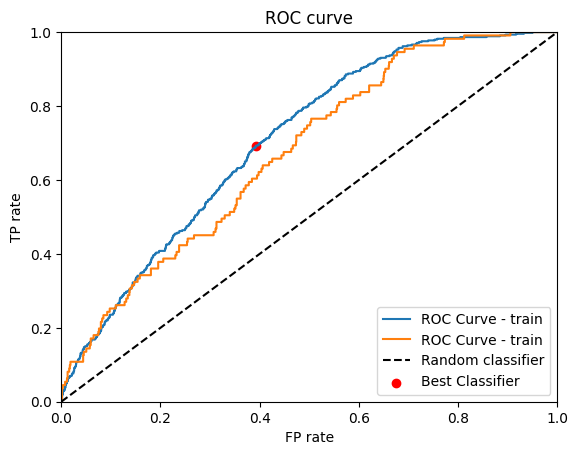

In [2]:
# Simulacoes para o SGD Classifier II
data = pd.read_csv("dados_hospital.csv", sep=',')
data.dropna(inplace=True)
target = 'no_show'
mapeamento = {'SIM': 0, 'NÃO': 1}
data[target] = data[target].map(mapeamento).astype(int)
data = data[data["distance"]<1000]
original_columns = list(data.columns[:-1])

categoricalvar = {cl:data[cl].dtypes == np.object0 for cl in original_columns} 

res = significancia(data,categoricalvar,target)
predictors = res["significantes"]

escala = [MinMaxScaler(),StandardScaler()]
regu = np.geomspace(0.01,1,5)
lossfct = ["hinge", "log_loss", "modified_huber", "squared_hinge", "huber"]
penalti = ["l1","l2"]

combinations = list(product(escala,regu,lossfct,penalti))

simulacoes =  pd.DataFrame()
for k,v in enumerate(combinations):
    print(f"modelo {k+1} de {len(combinations)} ",end='\r')
    pipe = Pipeline([('escala',v[0]),('modelo', SGDClassifier(loss=v[2],penalty=v[3],class_weight='balanced',alpha = v[1],max_iter=10000))])
    res = simulador_cv(pipe,data,predictors,target,categoricalvar,50)
    simulacoes[f"sim_{k+1}"] = res["geo_score"]

analise_sim = minha_anova(simulacoes.to_numpy().T,alpha=0.05)

data_train,data_test = train_test_split(data,test_size=0.2,stratify=data[target],random_state=None)
encodar = [cl for cl in original_columns if categoricalvar[cl]]
data_train,data_test = feat_transform(data_train,data_test,encodar,target,categoricalvar)
data_test = data_test.dropna()

X_train,y_train = data_train[predictors],data_train[target]
X_test,y_test = data_test[predictors],data_test[target]

idx = simulacoes.median().argmax()
esc = analise_sim["stats"][idx]["igual_idx"][0]
v = combinations[esc]

pipe = Pipeline([('escala',v[0]),('modelo', SGDClassifier(loss=v[2],penalty=v[3],class_weight='balanced',alpha = v[1],max_iter=50000))])
# search = cross_validate(pipe, X_train, y_train, scoring = my_scorer, cv = StratifiedKFold(5) , return_estimator=True)
# bests = search['estimator'][np.argmax(search['test_score'])]

search = minha_cross_val(pipe,data_train,predictors,target)
best_idx = search["best_idx"]
bests = search['estimators'][best_idx]


y_pred_test = predicao(bests,X_test)
y_pred_train = predicao(bests,X_train)

salvarpipes("sgd",bests,"pipe_paramns")

v = combinations[idx]
pipe1 = Pipeline([('escala',v[0]),('modelo', SGDClassifier(loss=v[2],penalty=v[3],class_weight='balanced',alpha = v[1],max_iter=10000))])
salvarpipes("sgd_idx",pipe1,"pipe_paramns")


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[geo_score,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
lst = analise_sim["stats"][idx]["igual_idx"]
simulacoes[[f"sim_{i+1}" for i in [esc,idx]]].plot.box()
[combinations[i] for i in [esc,idx]]

In [ ]:
corte = res["melhor"][2]
agrupado = agrupa_predicoes(bests,data_train,data_test,predictors,target,categoricalvar,corte)

In [ ]:
agrupado["metricas"]

In [ ]:
dir(bests.named_steps["modelo"])

In [ ]:
with open("pipe_paramns", 'r') as file:
     existing_data = json.load(file)

In [ ]:
existing_data["reg_linear"]